In [1]:
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import IPython.display as display
from matplotlib import animation
import torch
from torch.utils.data import DataLoader
import copy
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
import random
from dnaDataloader import expermentDataloader
from dnaDataloader import addData
from sklearn import preprocessing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 10
device

device(type='cuda', index=0)

In [2]:
def switchToDurration(expermentFrames):
    lastOne = 0
    for i in range(len(expermentFrames)):
        if expermentFrames[i]:
            expermentFrames[i] = i - lastOne if lastOne != 0 else 0
            lastOne = i
    return expermentFrames

Looks like changing the values to Durrations of events helps to prevent overfitting 

In [3]:
datasetLoaderlow = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low", 
)
datasetLoadermedium = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium", 
    # startIndex=0, endIndex=60
)
datasetLoaderHigh = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high", 
    # startIndex=0, endIndex=-1
)



rawData = [datasetLoaderlow[i] for i in list(range(len(datasetLoaderlow)))]
rawData = rawData + [datasetLoadermedium[i] for i in list(range(len(datasetLoadermedium)))]
rawData = rawData + [datasetLoaderHigh[i] for i in list(range(len(datasetLoaderHigh)))]
# rawData = [(switchToDurration(rawData[i][0]), rawData[i][1]) for i in list(range(len(rawData)))]
rawData = [[k,v] for k,v in rawData]
print(f"datasetlow:{len(datasetLoaderlow)}")
print(f"datasetmedium:{len(datasetLoadermedium)}")
print(f"datasetHigh:{len(datasetLoaderHigh)}")
print(f"Total: {len(datasetLoaderlow) + len(datasetLoadermedium) + len(datasetLoaderHigh)}")

datasetlow:56
datasetmedium:16
datasetHigh:84
Total: 156


Training dataset size: 126
Testing dataset size: 18
Valid dataset size: 12
Total: 156
number train batches:13
number test batches:2
number valid batches:2


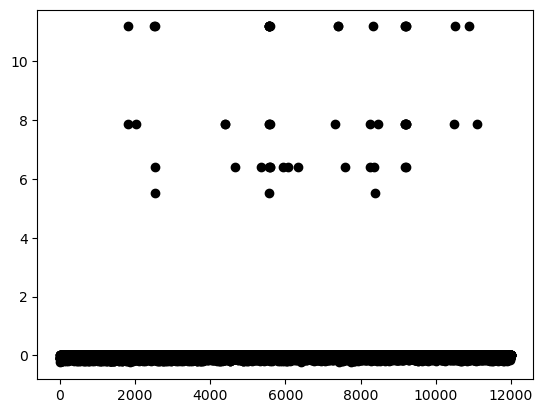

In [4]:

datasetlow = rawData[:len(datasetLoaderlow)]
datasetmedium = rawData[len(datasetlow):len(datasetlow)+len(datasetLoadermedium)]
datasetHigh = rawData[len(datasetlow)+len(datasetmedium):]
np.random.shuffle(datasetlow)
np.random.shuffle(datasetmedium)
np.random.shuffle(datasetHigh)
trainData = []
testValid = []

addData(trainData, testValid, datasetlow, rhsSize=int(len(datasetlow)*0.2))
addData(trainData, testValid, datasetmedium, rhsSize=int(len(datasetmedium)*0.2))
addData(trainData, testValid, datasetHigh, rhsSize=int(len(datasetHigh)*0.2))

trainFrames, trainTargets = list(zip(*trainData))
testFrames, testTargets = list(zip(*testValid))

std_scale = preprocessing.StandardScaler().fit(trainFrames)
normalized_durrations = std_scale.transform(trainFrames)
trainFrames = normalized_durrations
normalized_durrations = std_scale.transform(testFrames)
testFrames = normalized_durrations

trainData = tuple(zip(trainFrames, trainTargets))
testValid = tuple(zip(testFrames, testTargets))

testData = []
validData = []
addData(testData, validData, testValid, rhsSize=int(len(testValid)*0.6))

trainData = [([np.array(i).flatten(), np.array(t)]) for i,t in trainData]
testData = [([np.array(i).flatten(), np.array(t)]) for i,t in testData]
validData = [([np.array(i).flatten(), np.array(t)]) for i,t in validData]

trainDataset = DataLoader(trainData, batch_size=batch_size, shuffle=True)
testDataset = DataLoader(testData, batch_size=batch_size, shuffle=True)
validDataset = DataLoader(validData, batch_size=batch_size, shuffle=True)
print(f"Training dataset size: {len(trainData)}")
print(f"Testing dataset size: {len(validData)}")
print(f"Valid dataset size: {len(testData)}")
print(f"Total: {len(trainData) + len(validData) + len(testData)}")
print(f"number train batches:{len(trainDataset)}")
print(f"number test batches:{len(testDataset)}")
print(f"number valid batches:{len(validDataset)}")
featIn = len(trainData[0][0])
assert (len(datasetlow) + len(datasetmedium) + len(datasetHigh)) == (len(trainData) + len(validData) + len(testData))
plt.plot(list(range(len(trainData[0][0]))), trainData[0][0], 'o', color='black')

In [5]:
featIn = len(trainData[0][0])
print(trainData[0])
print(np.array(trainData[0][0]).max())
print(np.array(trainData[0][0]).min())

[array([-0.24253563,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ]), array([93])]
11.18033988749895
-0.24253562503633314


In [6]:
featIn

12000

In [7]:
device

device(type='cuda', index=0)

In [10]:
model = nn.Sequential(
          nn.Linear(featIn,700),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(700,700),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(700,700),
          nn.ReLU(),
          nn.Linear(700,1),
        )
# model = torch.nn.DataParallel(model)
model.to(device)
MSE = nn.MSELoss(reduction = 'sum')
adam = torch.optim.Adam(model.parameters(),lr=0.000001,weight_decay=1e-5)

em = 20
epochs = 10000
losses = []
accs = []
print("training...")
for e in range(epochs): 
  import IPython
  avgLossTrain = []
  currentAccTrain = []
  model.train()
  for i, (inputs, targets) in enumerate(trainDataset):
      inputs, targets= inputs.float().to(device), targets.float().to(device)
      outputs = model(inputs)
      loss = MSE(outputs, targets)
      avgLossTrain.append(float(loss.item()))
      adam.zero_grad()
      loss.backward()
      adam.step()
      totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
      totalCorrect = totalCorrect.item()
      currentAccTrain.append(float(totalCorrect/len(targets)))
  avgLoss = []
  currentAcc = []
  model.eval()
  for i, (inputs, targets) in enumerate(validDataset):
      inputs, targets= inputs.float().to(device), targets.float().to(device)
      outputs = model(inputs)
      loss = MSE(outputs, targets)
      avgLoss.append(float(loss.item()))
      totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
      totalCorrect = totalCorrect.item()
      currentAcc.append(float(totalCorrect/len(targets)))
      print(f"\
      epoch: {e}/{epochs}\t \
      Train Loss:{'%.4f' % (np.sum(avgLossTrain)/len(avgLossTrain))} Valid Loss:{'%.4f' % (np.sum(avgLoss)/len(avgLoss))}\t \
      Train accuracy:{'%.4f' % (np.sum(currentAccTrain)/len(currentAccTrain))} Valid accuracy:{'%.4f' % (np.sum(currentAcc)/len(currentAcc))} \
      ",end="\x1b\r")
  accs.append(float(np.sum(currentAcc)/len(currentAcc)))
  losses.append(float(np.sum(avgLoss)/len(avgLoss)))

training...


20000

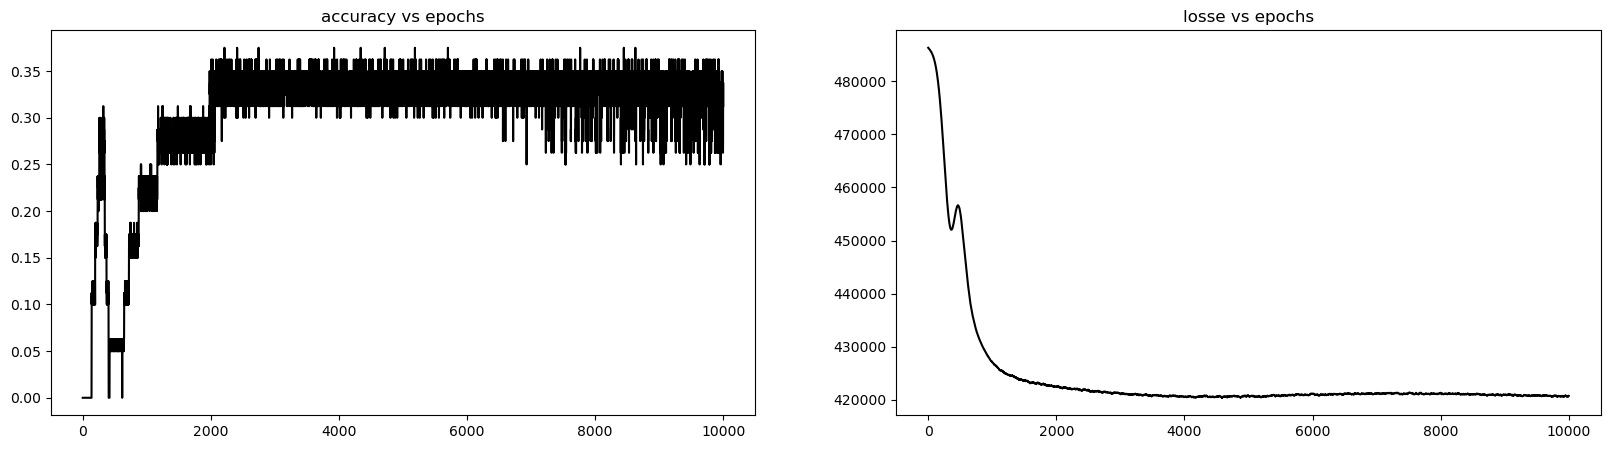

In [11]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1, 2, 1)
plt.title('accuracy vs epochs')
plt.plot(list(range(len(accs))), accs, '-', color='black', )
plt.subplot(1, 2, 2)
plt.title('losse vs epochs')
plt.plot(list(range(len(losses))), losses, '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize
epochs*len(validDataset)

check over fittness

training...


200

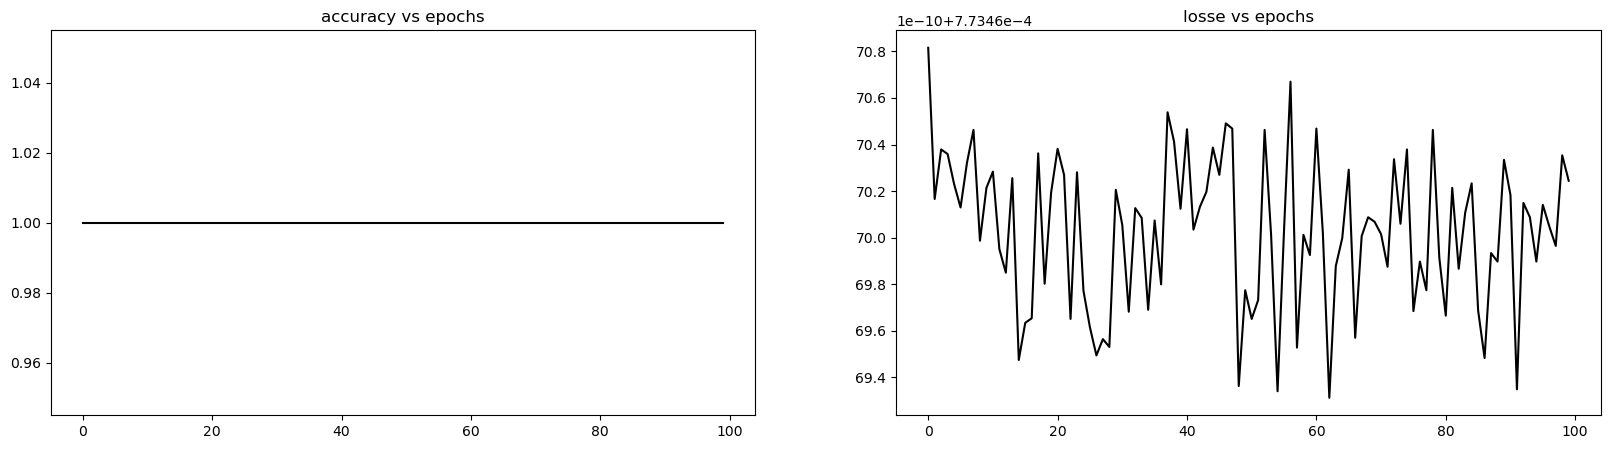

In [24]:
em = 20
epochs = 100
losses = []
accs = []
print("training...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    model.eval()
    for i, (inputs, targets) in enumerate(trainDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        avgLoss.append(float(loss.item()))
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.item()
        currentAcc.append(float(totalCorrect/len(targets)))
        print(f"\
        epoch: {e}/{epochs}\t \
        loss:{np.sum(avgLoss)/len(avgLoss)}\t \
        accuracy:{np.sum(currentAcc)/len(currentAcc)} \
        ",end="\x1b\r")
    accs.append(float(np.sum(currentAcc)/len(currentAcc)))
    losses.append(float(np.sum(avgLoss)/len(avgLoss)))
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1, 2, 1)
plt.title('accuracy vs epochs')
plt.plot(list(range(len(accs))), accs, '-', color='black', )
plt.subplot(1, 2, 2)
plt.title('losse vs epochs')
plt.plot(list(range(len(losses))), losses, '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize
epochs*len(validDataset)

In [20]:
from datetime import datetime
title = "2 hidden layers at 15000 loss stuck at about 30000 after 700 epochs"
dt_string = datetime.now().strftime("%d.%m.%Y_%H-%M-%S-%f")
modelPath = f"./Models/{title.replace(' ', '_')}_{dt_string}.pt"
torch.save(model.state_dict(),modelPath)
print(f"saved to {modelPath}")

saved to ./Models/2_hidden_layers_at_15000_loss_stuck_at_about_30000_after_700_epochs_10.05.2023_15-25-50-004175.pt


In [17]:
em =20
epochs = 100
accs = []
model.eval()
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        if(len(outputs) == batch_size):
            outputPlot = outputs.clone().detach().cpu().numpy()
            targetsPlot = targets.clone().detach().cpu().numpy()
            totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
            totalCorrect = totalCorrect.clone().detach().cpu().numpy()
            currentAcc.append(float(totalCorrect/len(targets)))
            accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

test...


200

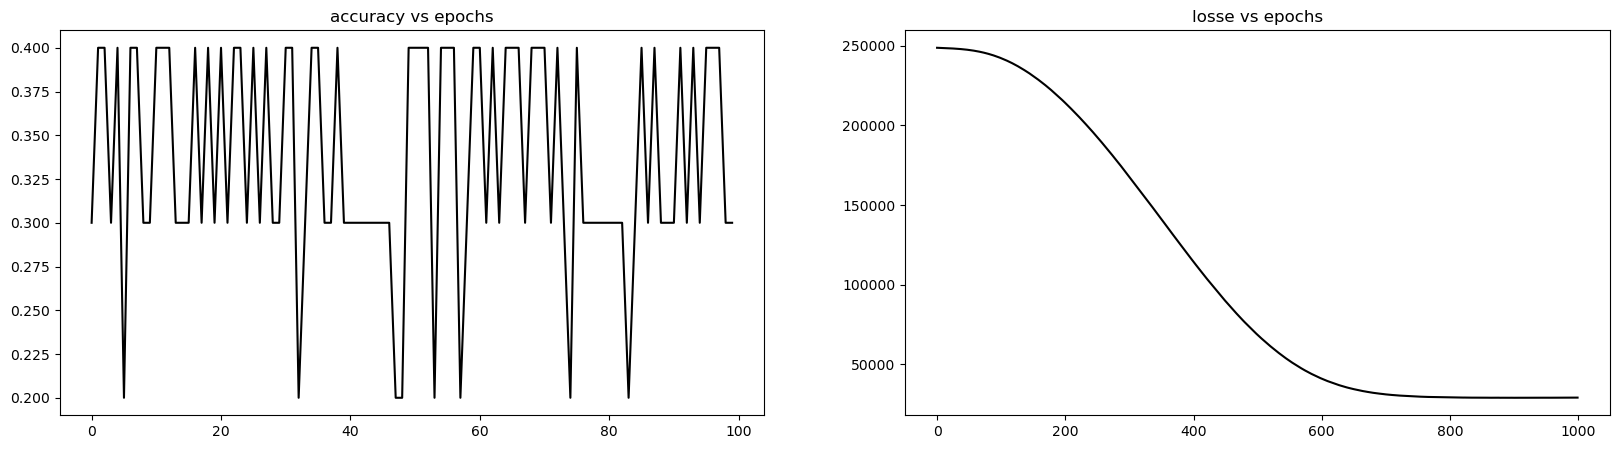

In [18]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1, 2, 1)
plt.title('accuracy vs epochs')
plt.plot(list(range(len(accs))), accs, '-', color='black', )
plt.subplot(1, 2, 2)
plt.title('losse vs epochs')
plt.plot(list(range(len(losses))), losses, '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize
epochs*len(validDataset)

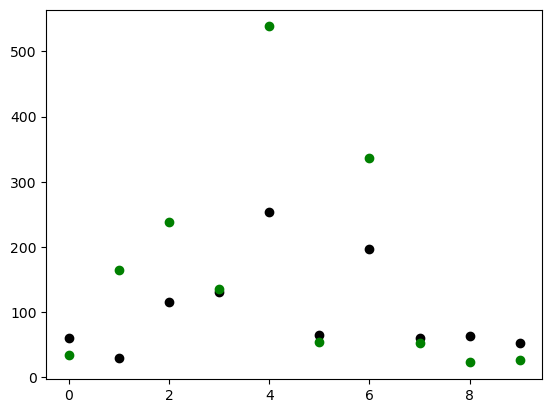

In [19]:
plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black')
plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green')

In [19]:
device

device(type='cuda', index=1)

In [20]:
model = nn.Sequential(
          nn.Linear(featIn,12000),
          nn.ReLU(),
          nn.Linear(12000,24000),
          nn.ReLU(),
          nn.Linear(24000,24000),
          nn.ReLU(),
          nn.Linear(24000,1),
        )
PATH = modelPath
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

Sequential(
  (0): Linear(in_features=12000, out_features=12000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12000, out_features=24000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24000, out_features=24000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24000, out_features=1, bias=True)
)

#### High
----

In [21]:
# testHigh = [i for i in testData if i[0][-2] in [9,5]]
# print(len(testHigh))
# testDatasetHigh = DataLoader(testHigh, batch_size=len(testHigh), shuffle=True)
# testHigh

In [22]:
# len(testHigh)

In [23]:
# em =137
# epochs = 100
# accs = []
# print("test...")
# for e in range(epochs): 
#     avgLoss = []
#     currentAcc = []
#     for i, (inputs, targets) in enumerate(testDatasetHigh):
#         inputs, targets= inputs.float().to(device), targets.float().to(device)
#         outputs = model(inputs)
#         outputPlot = outputs.clone().detach().cpu().numpy()
#         targetsPlot = targets.clone().detach().cpu().numpy()
#         totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
#         totalCorrect = totalCorrect.clone().detach().cpu().numpy()
#         currentAcc.append(float(totalCorrect/len(targets)))
#         accs.append(float(totalCorrect/len(targets)))

# print(f"\
#     accuracy:{np.sum(accs)/len(accs)} \
#     ",end="\x1b\r")

In [24]:
# plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black', label="predicted")
# plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green', label="actual")
# plt.xticks(ticks=list(range(len(outputPlot))), labels=list(range(len(outputPlot))))
# plt.xlabel('test case')
# plt.ylabel('number of reactions')
# plt.title('high reactivity')
# plt.legend(loc='upper right')

#### medium
----

In [25]:
# testmedium = [i for i in testData if i[0][-2] in [3.0]]
# testDatasetmedium = DataLoader(testmedium, batch_size=len(testmedium), shuffle=True)
# testmedium

In [26]:

# em =45
# epochs = 100
# accs = []
# print("test...")
# for e in range(epochs): 
    
#     avgLoss = []
#     currentAcc = []
#     for i, (inputs, targets) in enumerate(testDatasetmedium):
#         inputs, targets= inputs.float().to(device), targets.float().to(device)
#         outputs = model(inputs)
#         outputPlot = outputs.clone().detach().cpu().numpy()
#         targetsPlot = targets.clone().detach().cpu().numpy()
#         totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
#         totalCorrect = totalCorrect.clone().detach().cpu().numpy()
#         currentAcc.append(float(totalCorrect/len(targets)))
#         accs.append(float(totalCorrect/len(targets)))

# print(f"\
#     accuracy:{np.sum(accs)/len(accs)} \
#     ",end="\x1b\r")

In [27]:
# plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black', label="predicted")
# plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green', label="actual")
# plt.xticks(ticks=list(range(len(outputPlot))), labels=list(range(len(outputPlot))))
# plt.xlabel('test case')
# plt.ylabel('number of reactions')
# plt.title('medium reactivity')
# plt.legend(loc='upper right')

#### low
----

In [28]:

# testLow = [i for i in testData if i[0][-2] in [2.0,1.5]]
# testDatasetLow = DataLoader(testLow, batch_size=len(testLow), shuffle=True)
# len(testLow)

In [29]:

# em =20
# epochs = 100
# accs = []
# print("test...")
# for e in range(epochs): 
#     avgLoss = []
#     currentAcc = []
#     for i, (inputs, targets) in enumerate(testDatasetLow):
#         inputs, targets= inputs.float().to(device), targets.float().to(device)
#         outputs = model(inputs)
#         outputPlot = outputs.clone().detach().cpu().numpy()
#         targetsPlot = targets.clone().detach().cpu().numpy()
#         totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
#         totalCorrect = totalCorrect.clone().detach().cpu().numpy()
#         currentAcc.append(float(totalCorrect/len(targets)))
#         accs.append(float(totalCorrect/len(targets)))

# print(f"\
#     accuracy:{np.sum(accs)/len(accs)} \
#     ",end="\x1b\r")

In [30]:
# plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black', label="predicted")
# plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green', label="actual")
# plt.xticks(ticks=list(range(len(outputPlot))), labels=list(range(len(outputPlot))))
# plt.xlabel('test case')
# plt.ylabel('number of reactions')
# plt.title('low reactivity')
# plt.legend(loc='upper right')

#### large dataset
----

In [31]:
modelPath = "./Models/working_with_just_the_values_no_experment_setup_01.05.2023_15-47-12-842709.pt"

In [32]:
model = nn.Sequential(
          nn.Linear(featIn,12000),
          nn.ReLU(),
          nn.Linear(12000,24000),
          nn.ReLU(),
          nn.Linear(24000,24000),
          nn.ReLU(),
          nn.Linear(24000,1),
        )
model.load_state_dict(torch.load(modelPath))
model.to(device)
model.eval()

Sequential(
  (0): Linear(in_features=12000, out_features=12000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12000, out_features=24000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24000, out_features=24000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24000, out_features=1, bias=True)
)

In [33]:
datasetLarge = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/", 
)
print(f"datasetLarge:{len(datasetLarge)}")

datasetLarge:3862


In [39]:
rawData = [datasetLarge[i] for i in list(range(len(datasetLarge)))]


addData(trainData, testValid, rawData, rhsSize=int(len(rawData)*0.2))
testData = []
validData = []
addData(testData, validData, testValid, rhsSize=int(len(testValid)*0.6))

trainDataset = DataLoader(trainData, batch_size=batch_size, shuffle=True)
testDataset = DataLoader(testData, batch_size=batch_size, shuffle=True)
validDataset = DataLoader(validData, batch_size=batch_size, shuffle=True)
print(f"Training dataset size: {len(trainData)}")
print(f"Testing dataset size: {len(validData)}")
print(f"Valid dataset size: {len(testData)}")
print(f"Total: {len(trainData) + len(validData) + len(testData)}")
print(f"number train batches:{len(trainDataset)}")
print(f"number test batches:{len(testDataset)}")
print(f"number valid batches:{len(validDataset)}")

Training dataset size: 7112
Testing dataset size: 494
Valid dataset size: 330
Total: 7936
number train batches:712
number test batches:33
number valid batches:50


In [1]:
model = nn.Sequential(
          nn.Linear(featIn,12000),
          nn.ReLU(),
          nn.Linear(12000,24000),
          nn.ReLU(),
          nn.Linear(24000,24000),
          nn.ReLU(),
          nn.Linear(24000,1),
        )
model.to(device)
MSE = nn.MSELoss(reduction = 'sum')
adam = torch.optim.Adam(model.parameters(),lr=0.000001)

em = 20
epochs = 100
losses = []
accs = []
print("training...")
for e in range(epochs): 
    model.train()
    for i, (inputs, targets) in enumerate(trainDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        adam.zero_grad()
        loss.backward()
        adam.step()
        
    avgLoss = []
    currentAcc = []
    model.eval()
    for i, (inputs, targets) in enumerate(validDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        avgLoss.append(float(loss.clone().detach().cpu().numpy()))
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        print(f"\
        epoch: {e}/{epochs}\t \
        loss:{np.sum(avgLoss)/len(avgLoss)}\t \
        accuracy:{np.sum(currentAcc)/len(currentAcc)} \
        ",end="\x1b\r")
    accs.append(float(np.sum(currentAcc)/len(currentAcc)))
    losses.append(float(np.sum(avgLoss)/len(avgLoss)))

NameError: name 'nn' is not defined

In [ ]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1, 2, 1)
plt.title('accuracy vs epochs')
plt.plot(list(range(len(accs))), accs, '-', color='black', )
plt.subplot(1, 2, 2)
plt.title('losse vs epochs')
plt.plot(list(range(len(losses))), losses, '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize
epochs*len(validDataset)

In [ ]:
from datetime import datetime
title = "working with large dataset"
dt_string = datetime.now().strftime("%d.%m.%Y_%H-%M-%S-%f")
modelPath = f"./Models/{title.replace(' ', '_')}_{dt_string}.pt"
torch.save(model.state_dict(),modelPath)
print(f"saved to {modelPath}")

test...


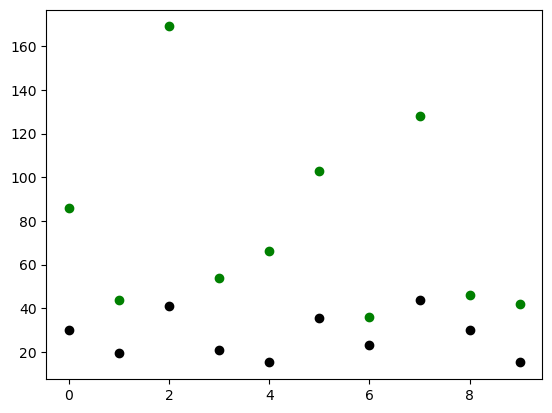

In [36]:
em =40
epochs = 50
accs = []
model.eval()
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(largeDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        if(len(outputs) == batch_size):
            outputPlot = outputs.clone().detach().cpu().numpy()
            targetsPlot = targets.clone().detach().cpu().numpy()
            totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
            totalCorrect = totalCorrect.clone().detach().cpu().numpy()
            currentAcc.append(float(totalCorrect/len(targets)))
            accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black')
plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green')